# PROJET: CLASSIFICATION DU TYPE DE TUMEUR

L'objectif de ce projet est de prédire le type de tumeur à partir d'images X-ray de cerveaux.

In [157]:
import pandas as pd 
import numpy as np
import PIL
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

## Préparation des données

Tout d'abord on met toutes les images à la meme taille et on convertit les images en tenseur.

In [158]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

Ensuite on charge les images.

In [159]:
training_set = ImageFolder(root= '/home/paul/brain_tumor_imgs/Training', transform= transform)

testing_set = ImageFolder(root= '/home/paul/brain_tumor_imgs/Testing', transform= transform)

On observe les classes suivantes.

In [160]:
print(f"Classes: {training_set.classes}")

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [162]:
type(training_set)

torch.utils.data.dataset.Subset

On charge les données en plusieurs lots de 16 images.

In [163]:
training_loader = DataLoader(training_set, batch_size= 16, shuffle = True)

validation_loader = DataLoader(validation_set, batch_size= 16, shuffle = True)

testing_loader = DataLoader(testing_set, batch_size= 16, shuffle = True)

**Affichage des images**

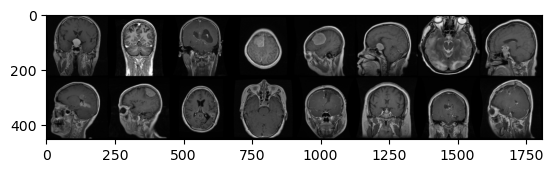

In [164]:
dataiter = iter(training_loader)

img, lab = next(dataiter)

def show_img(img):

    img = np.array(img)

    img = np.transpose(img, (1,2,0))

    plt.imshow(img)

    plt.show()

show_img(torchvision.utils.make_grid(img))

**Labels associés aux images**

In [165]:
lab

tensor([1, 2, 0, 1, 1, 1, 2, 3, 0, 1, 0, 3, 0, 3, 0, 0])

In [166]:
print([testing_set.classes[l] for l in lab])

['meningioma_tumor', 'no_tumor', 'glioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'glioma_tumor', 'pituitary_tumor', 'glioma_tumor', 'glioma_tumor']


**Calcul de la moyenne et de l'écart-type approximatif des images pour la normalisation**

In [167]:
import torch

# Initialisation des variables
moyenne = torch.zeros(3)       # Pour les 3 canaux (R, G, B)
ecart_type = torch.zeros(3)    # Pour les 3 canaux (R, G, B)
n_batchs = 0

# Calcul des moyennes et écarts-types cumulés
for data in training_loader:
    img, _ = data

    # Calcul de la moyenne et de l'écart-type pour chaque canal
    moyenne += img.mean(dim=[0, 2, 3])  # Moyenne des pixels par canal
    ecart_type += img.std(dim=[0, 2, 3])  # Écart-type des pixels par canal

    n_batchs += 1

# Calcul final des moyennes et écarts-types
moyenne /= n_batchs
ecart_type /= n_batchs

print("Moyenne des canaux (RVB) :", moyenne)
print("Écart-type des canaux (RVB) :", ecart_type)


Moyenne des canaux (RVB) : tensor([0.1787, 0.1787, 0.1787])
Écart-type des canaux (RVB) : tensor([0.1852, 0.1852, 0.1852])


**Normalisation**

In [168]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor() ,transforms.Normalize(mean = moyenne, std = ecart_type)])

**Chargement du modèle Resnet50 avec des poids initiaux préentrainés**

In [169]:
model = models.resnet50(weights = 'ResNet50_Weights.DEFAULT')

In [170]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Fine tunig du modèle**

On gèle toutes les couches et ensuite on dégèle les 3 dernières couches.

In [171]:
for param in model.parameters():

    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 4)

model.fc.requires_grad = True

model.layer4.requires_grad = True

model.layer3.requires_grad = True

model.layer2.requires_grad_ = True

**Critère et optimiseur**

In [172]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

**Entrainement**

In [173]:
epochs = 20

for epoch in range(epochs):

    model.train()

    running_loss = 0

    for data in training_loader:

        img, lab = data

        lab_pred = model(img)

        loss = criterion(lab_pred, lab)

        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%1 == 0:

        print(f"Epoch: {epoch+1}/{epochs} <--> Erreur sur le train: {running_loss/len(training_loader)}")



Epoch: 1/20 <--> Erreur sur le train: 0.7387538649555709
Epoch: 2/20 <--> Erreur sur le train: 0.38919532692266834
Epoch: 3/20 <--> Erreur sur le train: 0.3496048395366718
Epoch: 4/20 <--> Erreur sur le train: 0.2745480003456275
Epoch: 5/20 <--> Erreur sur le train: 0.24544309512647386
Epoch: 6/20 <--> Erreur sur le train: 0.21977628537246752
Epoch: 7/20 <--> Erreur sur le train: 0.1873200602001614
Epoch: 8/20 <--> Erreur sur le train: 0.17776670844371742
Epoch: 9/20 <--> Erreur sur le train: 0.18410714256202076
Epoch: 10/20 <--> Erreur sur le train: 0.17362846479712365
Epoch: 11/20 <--> Erreur sur le train: 0.16404624910662985
Epoch: 12/20 <--> Erreur sur le train: 0.13452037371381367
Epoch: 13/20 <--> Erreur sur le train: 0.1632522064828663
Epoch: 14/20 <--> Erreur sur le train: 0.18834392579932077
Epoch: 15/20 <--> Erreur sur le train: 0.17004460505914823
Epoch: 16/20 <--> Erreur sur le train: 0.18058418917644303
Epoch: 17/20 <--> Erreur sur le train: 0.14079894324337752
Epoch: 18/2

Evaluation

In [174]:
all_preds = []

all_labels = []

with torch.no_grad():

    model.eval()

    for data in testing_loader:

        img, lab = data

        img_pred = model(img)

        _, pred = torch.max(img_pred, 1)

        all_preds.extend(pred.numpy())

        all_labels.extend(lab.numpy())



In [175]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [178]:
print(classification_report(all_labels, all_preds, target_names= testing_set.classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.23      0.37       100
meningioma_tumor       0.55      0.83      0.66       115
        no_tumor       0.67      0.95      0.79       105
 pituitary_tumor       1.00      0.62      0.77        74

        accuracy                           0.67       394
       macro avg       0.78      0.66      0.64       394
    weighted avg       0.76      0.67      0.64       394



**Performance du modèle**

Le modèle atteint une précision globale de 67 % sur l'ensemble de test. Cependant, les performances varient considérablement selon les classes :

Glioma_tumor :
Le modèle détecte peu efficacement cette catégorie, avec un rappel de seulement 23 %. Cela signifie qu'il ne reconnaît correctement qu'une petite partie des images de tumeurs gliomes. Bien que la précision soit de 92 %, ce résultat est dû au fait que le modèle classe rarement des images comme "glioma_tumor".

Meningioma_tumor :
Pour cette catégorie, le rappel est de 83 %, ce qui est bon. Cela signifie que la majorité des tumeurs méningiomes sont bien détectées. Toutefois, la précision n'est que de 55 %, ce qui indique que le modèle confond parfois d'autres classes avec des tumeurs méningiomes.

No_tumor :
Le modèle est très performant pour identifier les cerveaux sans tumeur, avec un rappel de 95 %. Cela signifie qu'il détecte presque toujours correctement les cas où il n'y a pas de tumeur.

Pituitary_tumor :
La précision est excellente (100 %), mais le rappel est limité à 62 %. Cela signifie que lorsque le modèle prédit cette classe, il ne se trompe jamais, mais il rate encore certains cas de tumeurs pituitaires.

En résumé :
Le modèle fonctionne particulièrement bien pour la classe "no_tumor" et présente des résultats encourageants pour "meningioma_tumor".
Les classes "glioma_tumor" et "pituitary_tumor" posent plus de difficultés, car elles sont soit rarement détectées (glioma_tumor), soit partiellement ignorées (pituitary_tumor).
Le modèle a encore besoin d'améliorations, notamment pour équilibrer ses performances entre les différentes classes. Cela pourrait être amélioré en utilisant davantage de données ou des techniques comme l'augmentation de données ou le fine-tuning du modèle.